# Анализ вакансий тестировщиков для QA–факультета

### Цель исследования

Выбрать и проанализировать вакансии, на которые студенты QA-факультета могут откликнуться и получить приглашение на интервью.
Оценить объем рынка вакансий для начинающих тестировщиков.

### Разделы исследования

1. [Открытие и предобработка данных](#start)
    * [Загрузка данных](#start)
    * [Предобработка данных](#nulls)
    * [Отбор вакансий для тестировщиков](#qa_filter)
    
    
2. [Анализ описаний вакансий и основных требований](#vac_description)  
    * [Иссследование часто используемых словосочетаний в описаниях вакансий](#grams)
    * [Иссследование требуемого опыта работы в вакансиях](#experience)
    * [Иссследование требуемых навыков в вакансиях](#skills)    
    * [Иссследование креативных описаний вакансий](#creativity)
    
    
3. [Анализ емкости рынка по годам](#market)
4. [Анализ емкости рынка по регионам и по годам](#region_year)
5. [Исследование вакансий с упоминанием «исследовательское тестирование»](#research_rest)
6. [Исследование вакансий с удаленной работой](#remote)
7. [Исследование вакансий с частичной занятостью](#part)
8. [Исследование сезонности распределения вакансий](#seasons)
9. [Исследование вакансий-стажировок](#intern)
10. [Анализ распределения слов «тестировщик», «QA» или «QC» в вакансиях для джуниор специалистов](#junior)
11. [Общие выводы](#summary)
12. [Рекоммендации](#recommend)

### 1. Выгрузка и подготовка данных <a id="start"></a>

In [1]:
#импорт всех необходимых библиотек
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords

#уберем предупреждения jupyter
import warnings 
warnings.filterwarnings('ignore') 

In [2]:
#скачивание стопслов
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vrnsaw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
path = '/datasets/'
jobs = pd.read_csv(path + 'jobs_yandex_prakt.csv', sep = '|')

In [4]:
jobs.head()

Unnamed: 0  vacancy_id                       vacancy_name  \
0       62986    22432537             Руководитель IT отдела   
1     1337306    20529248                    DevOps engineer   
2      147089    22269077                 Разработчик PL/SQL   
3      697962    22636695  Инженер первой линии техподдержки   
4      936066    23931472                        Программист   

                                 vacancy_description experience_required  \
0  <p><strong><em>!!!!!!!!!!!УВАЖАЕМЫЕ СОИСКАТЕЛИ...       up_to_6_years   
1  <p><strong>Мы предлагаем полную занятость на у...       up_to_6_years   
2  <p><strong>Требования к соискателям:</strong><...       up_to_3_years   
3  <p><strong>Логистическому центру сети магазино...       up_to_3_years   
4  <p> </p> <p> </p> <p>ТРЕБОВАНИЯ</p> <p>Наличие...       no_experience   

  type_of_employment work_schedule          publication_day  \
0               full      full_day  2017-08-30 00:00:00.000   
1               full        remote  2017-05-15 00:00:00.000   
2               full      full_day  2017-08-08 00:00:00.000   
3               full      full_day  2017-09-06 00:00:00.000   
4               full      flexible  2017-12-26 00:00:00.000   

                       city_name           region_name country_name  \
0                         Москва                Москва       Россия   
1                     Ставрополь   Ставропольский край       Россия   
2                         Рязань     Рязанская область       Россия   
3  Подольск (Московская область)    Московская область       Россия   
4                       Владимир  Владимирская область       Россия   

  list_of_profarea_ids                                list_of_skill_names  
0                    1                                             [None]  
1                    1                                             [None]  
2                    1  ['Atlassian Jira', 'SOAP', 'Oracle Pl/SQL', 'G...  
3                    1                                             [None]  
4                    1                                             [None]

In [5]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680561 entries, 0 to 680560
Data columns (total 13 columns):
Unnamed: 0              680561 non-null int64
vacancy_id              680561 non-null int64
vacancy_name            680561 non-null object
vacancy_description     680561 non-null object
experience_required     680561 non-null object
type_of_employment      680561 non-null object
work_schedule           680561 non-null object
publication_day         680561 non-null object
city_name               680561 non-null object
region_name             610122 non-null object
country_name            680561 non-null object
list_of_profarea_ids    680561 non-null object
list_of_skill_names     680561 non-null object
dtypes: int64(2), object(11)
memory usage: 67.5+ MB


In [6]:
jobs.duplicated().sum()

0

In [7]:
jobs['publication_day'] = pd.to_datetime(jobs['publication_day'], format = '%Y-%m-%d')
jobs['publication_year'] = jobs['publication_day'].dt.year
jobs['publication_month'] = jobs['publication_day'].dt.month

In [8]:
jobs[jobs['region_name'].isna()].groupby('country_name')['vacancy_id'].count().reset_index()

country_name  vacancy_id
0     Беларусь       39406
1    Казахстан       31026
2       Россия           7

В таблице 680561 строк без дубликатов. Вывод информации о таблицы показал, что колонка с датой публикации вакансии была в формате object, для этой колонки он был изменен на дату формата ГГ-ММ-ДД.

<a id="nulls"></a> Имеются пустые значеня в колонке регионов в основном для стран Беларусь и Казахстан. Необходимо их заполнить для дальнейшей работы. Для этого использовались таблицы csv, составленные на основе внешних данных, с городами и областями для [Беларуси](https://maps.vlasenko.net/list/belarus/) и [Казахстана](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%D0%B0_%D0%BF%D0%BE_%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F). 

In [9]:
belarus_regions = pd.read_csv(path + 'belarus_naseleny_punkty.csv', sep = ';')
belarus_regions.head()

region_blr   city_name
0  Брестская  Барановичи
1  Брестская    Городище
2  Брестская      Задвея
3  Брестская      Лесная
4  Брестская     Люшнево

In [10]:
jobs = pd.merge(jobs, belarus_regions, on = 'city_name', how = 'left')
jobs['region_name'] = jobs['region_name'].mask(pd.isnull, jobs['region_blr'])
jobs = jobs.drop('region_blr', axis = 1)

In [11]:
kazahstan_regions = pd.read_csv(path + 'kazahstan_naseleny_punkty.csv', sep = ';')
kazahstan_regions.head()

city_name      region_kzt
0      Алматы          Алматы
1  Нур-Султан      Нур-Султан
2     Шымкент         Шымкент
3      Актобе     Актюбинская
4   Караганда  Карагандинская

In [12]:
jobs = pd.merge(jobs, kazahstan_regions, on = 'city_name', how = 'left')
jobs['region_name'] = jobs['region_name'].mask(pd.isnull, jobs['region_kzt'])
jobs = jobs.drop('region_kzt', axis = 1)

In [13]:
jobs[jobs['region_name'].isna()].groupby('country_name')['vacancy_id'].count().reset_index()

country_name  vacancy_id
0     Беларусь          57
1    Казахстан         192
2       Россия           7

После добавления данных о регионах в таблице осталось незначительное количество пустых значений, которые не должны сильно повлиять на исследование.

<a id="qa_filter"></a>
Далее отберем только вакансии, связанные с тестами, QA и QC.

Для этого все написания вакансий были приведены к нижнему регистру. Был создан словарь с ключевыми словами, которые должны быть в названии вакансии. С помощью функции найдем наличие этих слов в названиях и отметим подходящие вакансии.

In [14]:
jobs['vacancy_name'] = jobs['vacancy_name'].str.lower()

In [15]:
test_dict = ({'тест', 'qa', 'qc', 'test', 'quality assurance', 'quality control', 'q/a', 'q/c'})

In [16]:
jobs['test'] = 0

In [17]:
def change_name(name):
    for value in test_dict:
        if name.count(value) > 0:
            return 1
    return 0

In [18]:
jobs['test'] = jobs['vacancy_name'].apply(change_name)

In [19]:
test_jobs = jobs.query('test == 1').reset_index(drop = True)

In [20]:
test_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22861 entries, 0 to 22860
Data columns (total 16 columns):
Unnamed: 0              22861 non-null int64
vacancy_id              22861 non-null int64
vacancy_name            22861 non-null object
vacancy_description     22861 non-null object
experience_required     22861 non-null object
type_of_employment      22861 non-null object
work_schedule           22861 non-null object
publication_day         22861 non-null datetime64[ns]
city_name               22861 non-null object
region_name             22861 non-null object
country_name            22861 non-null object
list_of_profarea_ids    22861 non-null object
list_of_skill_names     22861 non-null object
publication_year        22861 non-null int64
publication_month       22861 non-null int64
test                    22861 non-null int64
dtypes: datetime64[ns](1), int64(5), object(10)
memory usage: 2.8+ MB


После отбора вакансий, соответствующих условиям, в таблице осталось 22861 строка без пропусков.

### 2. Анализ описаний вакансий и основных требований <a id="vac_description"></a>

Дальше уберем из описания вакансий html тэги, специальные символы и приведем написание к нижнему регистру для возможности корректного анализа слов и словосочетаний.

In [21]:
test_jobs['vacancy_description'] = test_jobs['vacancy_description'].str.replace(r'\<[^\>]*\>', ' ').str.lower().replace(r"[\"\`«»&'№!/]",'', regex = True)

In [22]:
test_jobs.head()

Unnamed: 0  vacancy_id                     vacancy_name  \
0      287960    23920048                   тестировщик по   
1        2826    22786768        qa lead / automation lead   
2      762452    19385470             аналитик-тестировщик   
3     1201893    20553589           qa automation engineer   
4      424763    22549584  инженер по тестированию (qc/qa)   

                                 vacancy_description experience_required  \
0    обязанности:    - тестирование web-сайтов   ...       no_experience   
1    magenta   technology    мы - международная п...       up_to_6_years   
2    крупный системный интегратор приглашает анал...       up_to_3_years   
3   codeswat is looking for qa automation enginee...       up_to_3_years   
4   нтц аргус— российский разработчик систем клас...       up_to_6_years   

  type_of_employment work_schedule publication_day        city_name  \
0               full      full_day      2017-12-25           Москва   
1               full      full_day      2017-09-19           Самара   
2               full      full_day      2017-01-23           Москва   
3               full      full_day      2017-05-16            Минск   
4               full      flexible      2017-09-25  Санкт-Петербург   

         region_name country_name list_of_profarea_ids  \
0             Москва       Россия                    1   
1  Самарская область       Россия                    1   
2             Москва       Россия                    1   
3            Минская     Беларусь                    1   
4    Санкт-Петербург       Россия                    1   

                                 list_of_skill_names  publication_year  \
0                                             [None]              2017   
1  ['QA', 'XML', 'автоматизированное тестирование...              2017   
2                                             [None]              2017   
3                                             [None]              2017   
4  ['Тестирование пользовательского интерфейса', ...              2017   

   publication_month  test  
0                 12     1  
1                  9     1  
2                  1     1  
3                  5     1  
4                  9     1

Проведем лемматизацию слов и их подсчет.

In [23]:
#импорт библиотек для лемматизации и подсчета лемматизированных слов
from pymystem3 import Mystem
from collections import Counter

In [24]:
m = Mystem()

text = ' '.join(list(test_jobs['vacancy_description']))
lemmas = m.lemmatize(text)

In [25]:
lemmas = pd.Series(lemmas).value_counts().reset_index()
print(lemmas[lemmas[0] > 300]['index'].tolist())

[' ', ', ', '.', 'и', '   ', 'в', ';   ', 'тестирование', '-', 'с', 'работа', 'опыт', ' (', 'по', 'на', 'мы', ':      ', 'знание', 'and', 'разработка', 'для', 'компания', 'команда', '      ', 'система', 'тест', 'от', 'проект', 'требование', 'быть', '       ', ': ', '  ', 'of', 'приложение', 'офис', '     ', '    ', 'the', 'продукт', 'наш', 'тестовый', ');   ', ' - ', 'in', 'задача', 'год', 'to', 'процесс', 'возможность', 'условие', 'язык', 'уровень', 'работать', '          ', 'к', 'вы', 'умение', 'понимание', 'документация', ')', '        ', ';       ', 'автоматизация', 'технический', 'обязанность', ')   ', 'который', 'написание', 'результат', 'test', 'профессиональный', 'английский', 'или', 'не', 'web', 'функциональный', 'qa', 'with', 'новый', 'a', 'из', 'мобильный', 'навык', 'что', 'плата', 'заработный', 'анализ', 'experience', 'график', 'sql', 'свой', 'высокий', 'корпоративный', 'участие', 'кейс', 'программный', 'качество', 'testing', 'for', 'технология', 'рабочий', ':     ', 'разра

In [26]:
test_jobs[test_jobs['vacancy_description'].str.contains(r'тесттест')]

Unnamed: 0  vacancy_id  \
9239      1020927    26557340   
9654      1458919    27235837   
10473      740441    29127647   
11476     1392303    26652437   
15503       13840    27379153   
18498     1370911    30660182   
20790       64806    29666750   

                                            vacancy_name  \
9239   тестовая вакансия, не откликайтесь на нее. тес...   
9654   тестовая вакансия, не откликайтесь на нее. тес...   
10473  тестовая вакансия, не откликайтесь на нее. тес...   
11476        тестовая анонимная вакансия не откликайтесь   
15503  тестовая вакансия, не откликайтесь на нее. тес...   
18498  тестовая вакансия, не откликайтесь на нее. тес...   
20790  тестовая вакансия, не откликайтесь налмлмпл не...   

                                     vacancy_description experience_required  \
9239            тесттесттесттесттесттесттесттесттестт...       up_to_3_years   
9654            тесттесттесттесттесттесттесттесттестт...       up_to_3_years   
10473           тесттесттесттесттесттесттесттесттестт...       up_to_3_years   
11476           тесттесттесттесттесттесттесттесттестт...       up_to_3_years   
15503           тесттесттесттесттесттесттесттесттестт...       up_to_3_years   
18498           тесттесттесттесттесттесттесттесттестт...       up_to_3_years   
20790           тесттесттесттесттесттесттесттесттестт...       up_to_3_years   

      type_of_employment work_schedule publication_day   city_name  \
9239           volonteer      full_day      2018-06-26  Виловатово   
9654           volonteer      full_day      2018-08-08  Виловатово   
10473               full      full_day      2018-11-30  Виловатово   
11476               full      full_day      2018-07-02  Виловатово   
15503               full      full_day      2018-08-17  Виловатово   
18498               full      full_day      2019-03-20  Виловатово   
20790               full      full_day      2019-01-16  Виловатово   

               region_name country_name list_of_profarea_ids  \
9239   Республика Марий Эл       Россия                    1   
9654   Республика Марий Эл       Россия                    1   
10473  Республика Марий Эл       Россия                    1   
11476  Республика Марий Эл       Россия                    1   
15503  Республика Марий Эл       Россия                    1   
18498  Республика Марий Эл       Россия                    1   
20790  Республика Марий Эл       Россия                    1   

                                     list_of_skill_names  publication_year  \
9239                                              [None]              2018   
9654                                              [None]              2018   
10473                                             [None]              2018   
11476                                             [None]              2018   
15503  ['Регресcионное тестирование', 'Compatibility ...              2018   
18498                                             [None]              2019   
20790  ['Beta-тестирования', 'Unit Testing', 'Compati...              2019   

       publication_month  test  
9239                   6     1  
9654                   8     1  
10473                 11     1  
11476                  7     1  
15503                  8     1  
18498                  3     1  
20790                  1     1

После лемматизации в глаза бросилась длинная фраза "тесттесттест". Отфильтровав строки с таким словом, видно что это тестовые вакансии без возможности отклика. Отбросим их, для дальнейшего исследования они не нужны.

In [27]:
test_jobs = test_jobs[~test_jobs['vacancy_description'].str.contains(r'тесттесттест')]

<a id="grams"></a> Создадим функцию, которая будет принимать в качестве входных данных текст из колонки описания вакансий и возвращать "очищенный" набор слов. Функция проводит лемматизацию слов и исключает русские стоп-слова.

Далее очищенные слова разобьем с помощью `ngrams` на словосочетания из 2 слов, которые часто встречаются парами в описаниях вакансии.

In [28]:
def basic_clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('russian')
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [29]:
words = basic_clean(''.join(str(test_jobs['vacancy_description'].tolist())))

In [30]:
twograms = pd.Series(nltk.ngrams(words, 2)).value_counts().reset_index()
twograms.columns = ['gram', 'frequency']

In [31]:
twograms.head(20)

gram  frequency
0                        (опыт, работы)      27092
1                  (опыт, тестирования)       7548
2                              (тк, рф)       7199
3                   (заработная, плата)       6188
4         (автоматизации, тестирования)       5379
5                      (график, работы)       4993
6                    (требования, опыт)       4871
7              (тестовой, документации)       4252
8           (программного, обеспечения)       4251
9                  (тестирования, опыт)       4226
10                   (умение, работать)       3996
11                     (оформление, тк)       3923
12                     (experience, in)       3809
13              (мобильных, приложений)       3650
14  (автоматизированного, тестирования)       3647
15                 (английского, языка)       3634
16                     (гибкий, график)       3415
17                (тестовых, сценариев)       3118
18         (нагрузочного, тестирования)       3113
19                   (опыт, разработки)       3046

В вышепредставленной таблице содержатся достаточно общие словосочетания наиболее часто встречающиеся в описаниях вакансий. Треть вакансий привлекают законностью и прозврачностью в описании, упоминая оформление по ТК РФ, а также упоминают заработную плату, график работы и гибкий график работы. 

Часто от соискателей требуют наличия опыта тестирования и работы с тестовой документацией, в 3046 вакансиях упоминается об опыте разработки. Также одно из популярный требований - знание английского языка.

Одними из популярных направлений, с которыми предстоит работать будущим сотрудникам - автоматизация тестирования, мобильные приложения и нагрузочное тестирование.

Далее составим словарь с "общими" словами, которые больше относятся к оформлению, заработной плате и графику работы, чтобы исключить их и оценить только требования, которые фигурируют в описаниях. Дополнительно исключим английские стоп-слова.

На основе очищенных данных выделим часто встречающиеся словосочетания из 2 и 3 слов.

In [32]:
def basic_clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords_ru = nltk.corpus.stopwords.words('russian')
    stopwords_eng = nltk.corpus.stopwords.words('english')
    additional_stopwords = ({'график', 'опыт', 'тк', 'плата', 'платы' 'оформление', 'рф', 'заработная', 
                             'заработной', 'требования', 'день', 'дня', 'отпуск'})
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if (word not in stopwords_ru) and (word not in stopwords_eng) and (word not in additional_stopwords)]

In [33]:
words = basic_clean(''.join(str(test_jobs['vacancy_description'].tolist())))

In [34]:
twograms = pd.Series(nltk.ngrams(words, 2)).value_counts().reset_index()
twograms.columns = ['gram', 'frequency']

In [35]:
twograms.head(20)

gram  frequency
0         (автоматизации, тестирования)       5386
1              (тестовой, документации)       4252
2           (программного, обеспечения)       4251
3                    (умение, работать)       3996
4               (мобильных, приложений)       3650
5   (автоматизированного, тестирования)       3647
6                  (английского, языка)       3634
7          (нагрузочного, тестирования)       3118
8                 (тестовых, сценариев)       3118
9                             (1, года)       3000
10                  (работы, системами)       2858
11           (техническое, образование)       2855
12                  (карьерного, роста)       2755
13                (высшее, техническое)       2721
14               (понимание, принципов)       2640
15                    (базовые, знания)       2635
16                  (работать, команде)       2370
17                        (знание, sql)       2359
18               (тестирования, знание)       2264
19                      (знание, основ)       2262

Убрав слова о найме, графике работы и заработной плате, в таблице топ-20 часто повторяющихся словосочетаний появились новые элементы. 

Таким образом, видно, что для трудоустройства многие работодатели указывают в требованиях наличие высшего технического образования и знание SQL. Можно отметить, что тестировщикам предстоит ввести коммуникации с коллегами и другими командами, поэтому компании указывают в качестве требования "умение работать в команде".

Далее был применен метод `ngrams` для разделения на словосочетания из 3 элементов и построена диаграма частоты повторений.

In [36]:
threegrams = pd.Series(nltk.ngrams(words, 3)).value_counts().reset_index()
threegrams.columns = ['gram', 'frequency']

Text(0, 0.5, 'Словосочетания')

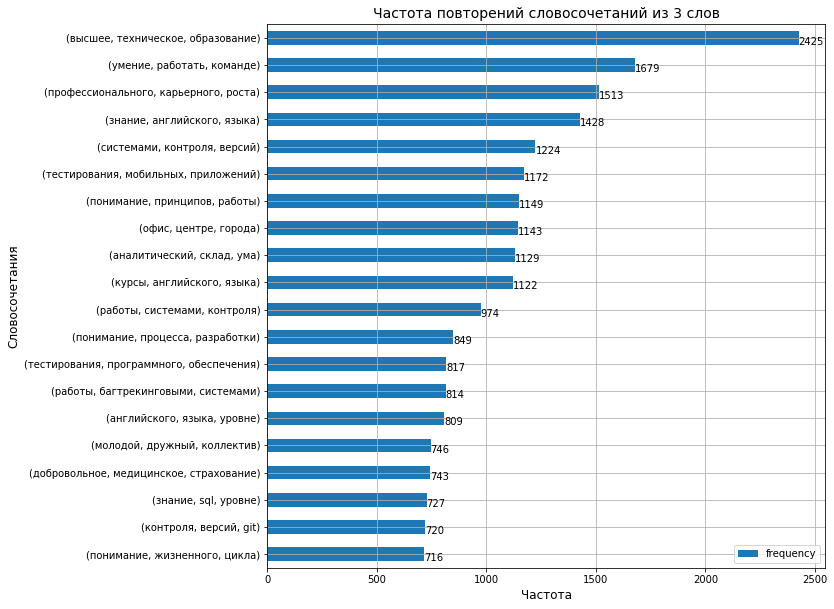

In [37]:
ax = threegrams.set_index('gram').head(20).plot(kind = 'barh', grid = True, figsize = (10, 10))
ax.invert_yaxis()
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_width()), (p.get_width(), p.get_y() + 0.4),
                    ha = 'left', va = 'center', color = 'black', fontsize = 10)
ax.set_title('Частота повторений словосочетаний из 3 слов', fontsize = 14)
ax.set_xlabel('Частота', fontsize = 12)
ax.set_ylabel('Словосочетания', fontsize = 12)

В данном распределении встречаются почти все ранее описанные характеристики: высшее техническое образование (которое теперь стоит на первом месте по частоте повторений), умение работать в команде, знание английского языка, тестирование мобильных приложений, работа с системами контроля, тестирование программного обеспечения, знание SQL.

Также от тестировщиков требуется наличие аналитического склада ума и понимание жизненного цикла разработки.

Помимо этого, добавились определенные пункты, которые не относятся к требованиям, а направлены на привлечение соискателей, такие как: профессиональный карьерный рост, офис в центре города, курсы английского языка (вероятно, предоставляемые компанией сотрудникам), молодой дружный коллектив  и добровольное медицинское страхование.

<a id="experience"></a> В twograms выше было видно, что часто встречается словосочетание "1 года". Далее отфильтровали вакансии, у которых в описании содержится фраза "от 1 года" и сгруппировали их по требуемому опыту работу. 

In [38]:
test_jobs[test_jobs['vacancy_description'].str.contains(r'от 1 года')].groupby('experience_required')['vacancy_id'].count()

experience_required
above_6_years       3
no_experience      74
up_to_3_years    2097
up_to_6_years     204
Name: vacancy_id, dtype: int64

In [39]:
test_jobs[test_jobs['vacancy_description'].str.contains(r'опыт работы не менее')].groupby('experience_required')['vacancy_id'].count()

experience_required
no_experience     7
up_to_3_years    82
up_to_6_years    38
Name: vacancy_id, dtype: int64

Из построенной таблицы видно, что в 74 вакансиях работодатели указывают, что опыт работы не требуется, однако в описании они указывают о желательном/необходимом опыте работы или опыте работы с конкретными системами от 1 года. Данные пункты противоречат друг другу и могут вводить в заблуждение соискателей.

Дополнительно отфильтровались по словосочению "опыт работы не менее". Имеется 7 вакансий, где в опыте работы указано "не требуется", однако в описании есть ограничение для опыта работы.

Похожая ситуация с вакансиями, где в описании указывают о том, что опыт работы не обязателен. В то же время в графе опыт работы указано - "до 3 лет".

In [40]:
test_jobs[test_jobs['vacancy_description'].str.contains(r'опыт работы не обязателен')].groupby('experience_required')['vacancy_id'].count()

experience_required
no_experience    6
up_to_3_years    2
Name: vacancy_id, dtype: int64

В целом, в вакансиях тестировщиков преобладает требование опыта работы "до 3 лет", они составляют 63,9%. На втором месте требование "до 6 лет". Вакансии "без опыта" занимают на рынке 12,8%.

In [41]:
experience_data = (test_jobs
                   .groupby('experience_required')['vacancy_id']
                   .count()
                   .reset_index()
                  )

experience_data.loc[0, 'experience_required'] = 'опыт работы свыше 6 лет'
experience_data.loc[1, 'experience_required'] = 'опыт работы не требуется'
experience_data.loc[2, 'experience_required'] = 'опыт работы до 3 лет'
experience_data.loc[3, 'experience_required'] = 'опыт работы до 6 лет'

experience_data = experience_data.set_index('experience_required')

Text(0, 0.5, 'Требуемый опыт работы')

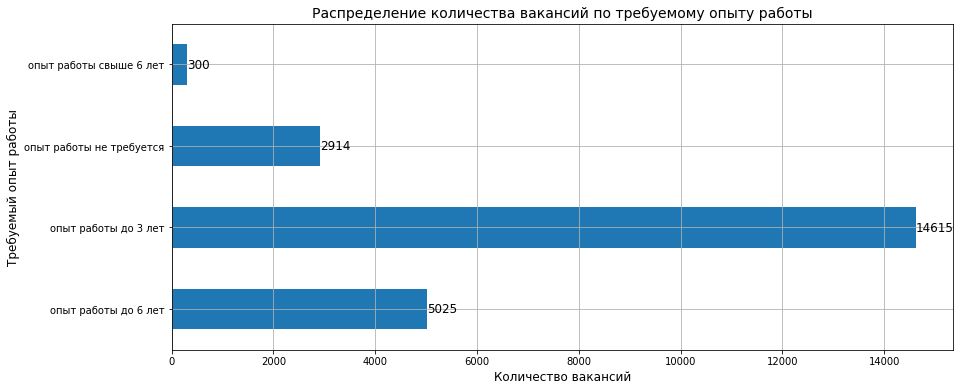

In [42]:
ax = experience_data.plot(kind = 'barh', grid = True, figsize = (14, 6), legend = False)
ax.invert_yaxis()
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_width()), (p.get_width(), p.get_y() + 0.25),
                    ha = 'left', va = 'center', color = 'black', fontsize = 12)
ax.set_title('Распределение количества вакансий по требуемому опыту работы', fontsize = 14)
ax.set_xlabel('Количество вакансий', fontsize = 12)
ax.set_ylabel('Требуемый опыт работы', fontsize = 12)

Среди вакансий младшего тестировщика преобладают вакансии "без опыта работы". Однако, даже среди вакансий джунов много вакансий, где от соискателей требуют наличия опыта работы до 3 лет.

In [43]:
test_jobs[test_jobs['vacancy_name'].str.contains(r'junior|младш')].groupby('experience_required')['vacancy_id'].count().reset_index()

experience_required  vacancy_id
0       no_experience         584
1       up_to_3_years         361
2       up_to_6_years           3

<a id="skills"></a> Далее посмотрим отдельно на перечень навыков, которые работодатели указывают в вакансиях. 

In [44]:
skills = basic_clean(''.join(str(test_jobs['list_of_skill_names'].tolist()).lower()))
skills_grams = pd.Series(ngrams(skills, 1)).value_counts().reset_index()
skills_grams.columns = ['gram', 'frequency']

In [45]:
skills_grams.head(15)

gram  frequency
0                (none,)      14365
1        (тестирование,)      11222
2                  (qa,)       2810
3      (функциональное,)       2602
4                 (sql,)       2427
5                (test,)       1654
6   (пользовательского,)       1621
7          (интерфейса,)       1621
8                (java,)       1525
9                (case,)       1377
10          (atlassian,)       1377
11               (jira,)       1364
12            (testing,)       1354
13           (selenium,)       1275
14      (регресcионное,)       1248

В большинстве вакансий не указываются требуемые навыки. Компании расписывают их в описании вакансий и не дублируют отдельно в перечне навыков.

Далее по популярности идет требование навыка тестирования. Ниже были извлечены уникальные значения колонки навыков, содержащие слово "тестирование". Из них видно, что требуются навыки автоматизированного тестирования, функционального тестирования, нагрузочного тестирования, регрессионного тестирования, тестирования пользовательского интерфейса и ручного тестирования.

SQL в требованиях к навыкам также является одним из популярных скиллов. К нему добавились требования знания Java и Atlassian.

In [46]:
test_jobs[test_jobs['list_of_skill_names'].str.contains(r'тестирование')]['list_of_skill_names'].unique()

array(["['QA', 'XML', 'автоматизированное тестирование', 'Автоматизация', 'Тестирование', 'SOAP', 'обучение сотрудников', 'SQL', 'Функциональное тестирование', 'Нагрузочное тестирование', 'Atlassian Jira', 'Регресcионное тестирование']",
       "['Тестирование пользовательского интерфейса', 'Функциональное тестирование', 'Black box testing', 'Регресcионное тестирование', 'Atlassian Jira', 'QA', 'Test case']",
       "['Функциональное тестирование', 'Регресcионное тестирование', 'Модульное тестирование']",
       ...,
       "['Тестирование', 'Функциональное тестирование', 'Регресcионное тестирование', 'Atlassian Jira', 'SQL', 'Linux']",
       "['Функциональное тестирование', 'Автоматизация', 'MS SQL', 'BDD Cucumber', 'Atlassian Jira']",
       "['Проведение тестирований', 'Atlassian Jira', 'Linux', 'СУБД', 'ручное тестирование', 'Test case']"],
      dtype=object)

 <a id="creativity"></a> Далее рассмотрим вакансии, содержащие в описании современные слова, которые отличаются от других своей креативностью и, возможно, нацеленностью на поиск молодых специалистов.

In [47]:
creative_vacancies = test_jobs[test_jobs['vacancy_description'].str.contains(r'креатив|плюшк|крут|клёв|клев|классны|ништяк|позитив')]

In [48]:
creative_vacancies.shape[0]

2321

In [49]:
creative_vacancies.groupby('publication_year')['vacancy_id'].count().reset_index()

publication_year  vacancy_id
0              2017         724
1              2018         740
2              2019         857

Text(0, 0.5, 'Частота')

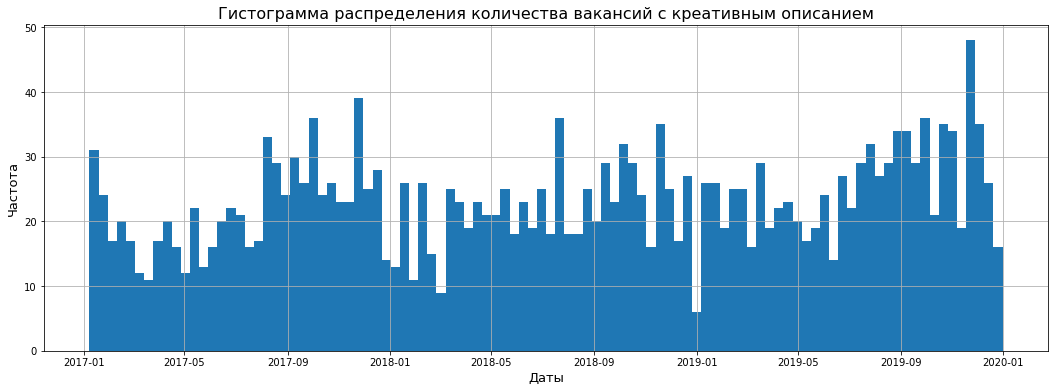

In [50]:
ax = creative_vacancies['publication_day'].hist(bins = 100, figsize = (18, 6))
ax.set_title('Гистограмма распределения количества вакансий с креативным описанием', fontsize = 16)
ax.set_xlabel('Даты', fontsize = 13)
ax.set_ylabel('Частота', fontsize = 13)

Во второй половине 2019 года количество вакансий с креативным и современным описанием выросло. Компании стремятся привлечь амбициозных и воодушевленных специалистов, привлекая их плюшками в виде тимбилдингов, печенек и т.д. Можно сказать, что такие вакансии часто направлены на более молодых соискателей из-за наличия подобных слов в описании. Вдобавок ранее было выявлено, что часто в описании вакансий указывают "молодой дружный коллектив". Возможно, как раз в этих вакансиях встречается такое креативное описание атмосферы в коллективе.

### 3. Анализ емкости рынка по годам  <a id="market"></a>

In [51]:
test_jobs.groupby('publication_year')['vacancy_id'].count().reset_index()

publication_year  vacancy_id
0              2017        8255
1              2018        7554
2              2019        7045

Text(0, 0.5, 'Частота')

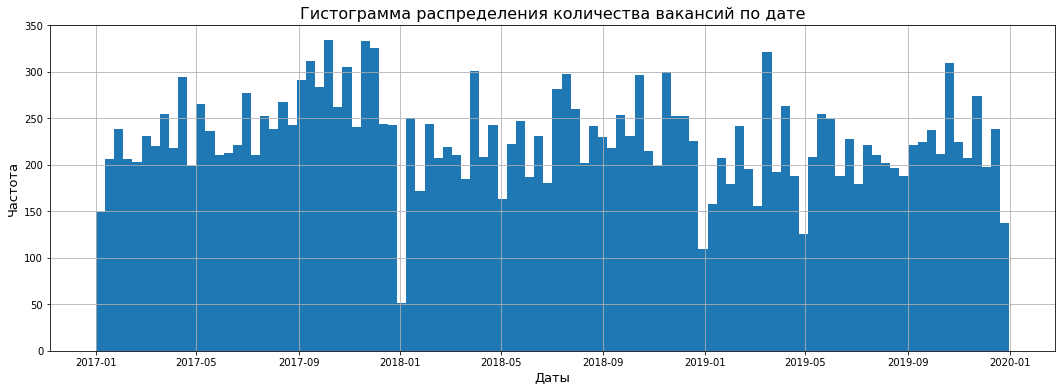

In [52]:
ax = test_jobs['publication_day'].hist(bins = 100, figsize = (18, 6))
ax.set_title('Гистограмма распределения количества вакансий по дате', fontsize = 16)
ax.set_xlabel('Даты', fontsize = 13)
ax.set_ylabel('Частота', fontsize = 13)

(36, 0)

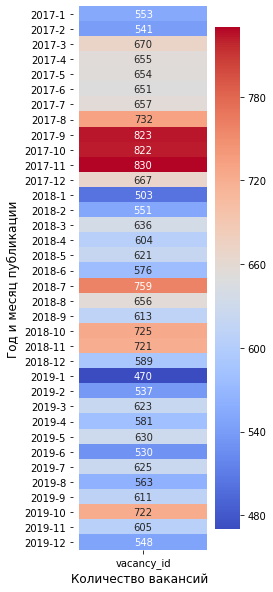

In [53]:
fig, ax = plt.subplots(figsize = (3,10))
sns.heatmap(test_jobs.pivot_table(index = ['publication_year', 'publication_month'], values = 'vacancy_id', 
                  aggfunc = 'count'), cmap='coolwarm', annot = True, fmt='.0f')
ax.set_xlabel('Количество вакансий', fontsize = 12)
ax.set_ylabel('Год и месяц публикации', fontsize = 12)
ax.set_xlim(1.05, 0)
ax.set_ylim(36, 0)

По графику видно, что в 2017 году количество вакансий тестировщиков больше, чем в последующие года. Далее количество только снижается. Также в 2017 году можно увидеть определенную стабильность, в течение года не наблюдается резких скачков и спадов. В 2018 и 2019 годах разница между количеством вакансий от месяца к месяцу варьируется, и эта разница больше, чем в 2017. 

В 2017 году наблюдался рост конкуренции и дефицит квалифицированных кадров, к тому же Сбербанк и его ИТ-«дочка» «СберТех» стали одной из действующих сил развития отрасли и роста количества вакансий. [1](https://zdirector.ru/tendentsii-i-perspektivy-rynka-autsorsingu-uslug-testirovaniya-programmnogo-obespecheniya/) 

### 4. Анализ емкости рынка по регионам и по годам  <a id="region_year"></a>

In [54]:
def market(country):
    country_year = (test_jobs[test_jobs['country_name'] == country]
                    .pivot_table(index = 'region_name', columns = 'publication_year', values = 'vacancy_id', aggfunc = 'count')
                    .fillna(0)
                   )
    return country_year

In [55]:
market('Россия')

publication_year       2017  2018  2019
region_name                            
Алтайский край         33.0  24.0  19.0
Амурская область        1.0   5.0   4.0
Архангельская область   5.0   4.0   6.0
Астраханская область    6.0   7.0   6.0
Белгородская область   19.0  28.0  22.0
...                     ...   ...   ...
Челябинская область    48.0  68.0  34.0
Чеченская республика    0.0   2.0   3.0
Чувашская Республика   24.0  28.0  22.0
Ямало-Ненецкий АО       1.0   3.0   0.0
Ярославская область    65.0  53.0  36.0

[79 rows x 3 columns]

In [56]:
market('Казахстан')

publication_year       2017  2018  2019
region_name                            
Актюбинская             1.0   0.0   0.0
Алматы                 73.0  72.0  65.0
Атырауская              2.0   3.0   6.0
Западно-Казахстанская   1.0   0.0   0.0
Карагандинская          7.0  13.0   4.0
Мангистауская           2.0   1.0   0.0
Нур-Султан             31.0  34.0  28.0
Павлодарская            5.0   1.0   1.0
Северо-Казахстанская    0.0   2.0   2.0
Шымкент                 1.0   0.0   0.0

In [57]:
market('Беларусь')

publication_year  2017  2018  2019
region_name                       
Брестская           21    27    21
Витебская           43    30    33
Гомельская          26    20    17
Гродненская         23    17    11
Минская            737   660   584
Могилевская         16     9     9

В регионах Казахстана и Беларуси тоже наблюдается спад количества ваканский к 2019 году, что и было выявлено ранее в общем распределении вакансий.

In [58]:
def market(country):
    country_year = (test_jobs[test_jobs['country_name'] == country]
                    .pivot_table(index = ['region_name', 'publication_year'], values = 'vacancy_id', aggfunc = 'count')
                    .fillna(0)
                   )
    return country_year

Российские регионы сложнее оценить по таблице из-за их количества, поэтому далее построим диаграмму для Москвы и Санкт-Петербурга и отдельно для топ-15 регионов России и распределения вакансий в них по годам. Москву и Санкт-Петербург лучше рассмотреть отдельно от остальных городов из-за разрыва в значениях, графики по другим городам будут "теряться" на их фоне.

In [59]:
top_15 = (test_jobs.query('(country_name == "Россия") & (region_name != "Москва") & (region_name != "Санкт-Петербург")')
          .pivot_table(index = 'region_name', values = 'vacancy_id', aggfunc = 'count')
          .reset_index()
          .sort_values(by = 'vacancy_id', ascending = False)
          .head(15)
         )['region_name'].tolist()

In [60]:
table_top_15 = market('Россия').reset_index().query('region_name in @top_15')
moscow_spb = market('Россия').reset_index().query('(region_name == "Москва") or (region_name == "Санкт-Петербург")')

In [61]:
moscow_spb['publication_year'] = moscow_spb['publication_year'].astype(str)
fig = px.bar(moscow_spb, x = "region_name", y = "vacancy_id", color = 'publication_year', barmode='group',
             height=600, title = 'Распределение вакансий по годам в Москве и Санкт-Петербурге')
fig.update_layout(xaxis = {'categoryorder':'total descending', 'title': 'Регион'},
                 yaxis = {'title': 'Количество вакансий'})
fig.show()

In [62]:
table_top_15['publication_year'] = table_top_15['publication_year'].astype(str)
fig = px.bar(table_top_15, x = "region_name", y = "vacancy_id", color = 'publication_year', barmode='group',
             height=600, title = 'Распределение вакансий по годам в топ-15 регионах')
fig.update_layout(xaxis = {'categoryorder': 'total descending', 'title': 'Регион'},
                 yaxis = {'title': 'Количество вакансий'})
fig.update_xaxes(tickangle = 45)
fig.show()

В Москве в 2018 и 2019 годах количество вакансий ниже, чем в 2017 году, однако незначительно и можно сказать, что количество вакансий по годам распределено практически равномерно. В Московской области самое большое количество вакансий тестировщиков на рынке труда наблюдалось в 2018 году.

В Санкт-Петербурге и Новосибирской области наблюдается общий тренд: в 2017 году количество значительно больше, чем в последующих годах и к 2019 году распределение вакансий стабильно падает. В остальных регионах также сохраняется тренд спада.

Из всей картины выделяются Краснодарский край и республика Башкортостан. В этих регионах виден резкий скачок количества вакансий в 2019 году. Возможно, это связано с множественным открытием новых IT-компаний и востребованностью специалистов данной сферы.

### 5. Исследование вакансий с упоминанием «исследовательское тестирование»   <a id="research_rest"></a>

In [63]:
test_share = test_jobs[test_jobs['vacancy_description'].str.contains('исследовательское тестирование')].shape[0]/test_jobs.shape[0]

In [64]:
print('Доля вакансий, в которой упоминается «исследовательское тестирование»: {:.2%}'.format(test_share))

Доля вакансий, в которой упоминается «исследовательское тестирование»: 2.24%


In [65]:
research_test = test_jobs[test_jobs['vacancy_description'].str.contains('исследовательское тестирование')]
research_test.shape[0]

512

In [66]:
words = basic_clean(''.join(str(research_test['vacancy_name'].tolist())))
grams = pd.Series(nltk.ngrams(words, 1)).value_counts().reset_index()
grams.columns = ['gram', 'frequency']
grams.head(10)

gram  frequency
0  (асессортестировщик,)        382
1                  (qa,)         73
2            (engineer,)         45
3         (тестировщик,)         33
4             (инженер,)         30
5        (тестированию,)         27
6          (специалист,)         17
7          (automation,)         17
8        (тестирования,)          8
9       (автоматизации,)          6

In [67]:
research_test.groupby('experience_required')['vacancy_id'].count()

experience_required
no_experience    105
up_to_3_years    380
up_to_6_years     27
Name: vacancy_id, dtype: int64

In [68]:
words = basic_clean(''.join(str(research_test['vacancy_description'].tolist())))
twograms = pd.Series(nltk.ngrams(words, 2)).value_counts().reset_index()
twograms.columns = ['gram', 'frequency']
twograms.head(10)

gram  frequency
0  (исследовательское, тестирование)        525
1            (ручного, тестирования)        409
2      (регрессионное, тестирование)        396
3          (сценариев, тестирования)        395
4              (продуктов, компании)        392
5             (тестирование, разных)        391
6             (написание, сценариев)        388
7              (тестирование, новых)        387
8  (тестирования, исследовательское)        386
9                  (таких, компаний)        384

Доля вакансий, в которой упоминается «исследовательское тестирование» занимает 2.24% (512 ед.) от общего числа.Среди них также в большей части вакансий в требуемом опыте работы отмечено "опыт работы до 3 лет". 

В описании вакансий преобладают различные типы тестирования: исследовательское, ручное, регрессионное. В таких вакансиях практически не наблюдается общих фраз об оформлении, графике работы или каких-либо других требуемых навыках кроме тестирования. 

### 6. Исследование вакансий с удаленной работой  <a id="remote"></a>

In [69]:
def remote(country):
    remote_regions = (test_jobs
                      .query('(country_name == @country) & (work_schedule == "remote")')
                      .groupby('region_name')['vacancy_id'].count()
                      .reset_index()
                      .set_index('region_name')
                      .sort_values(by = 'vacancy_id', ascending = False)
                     )
    return remote_regions

In [70]:
remote('Россия').head(10)

vacancy_id
region_name                      
Москва                        358
Санкт-Петербург               161
Республика Татарстан           62
Нижегородская область          59
Новосибирская область          55
Самарская область              50
Ростовская область             46
Саратовская область            46
Свердловская область           44
Краснодарский край             42

In [71]:
remote('Беларусь')

vacancy_id
region_name            
Минская              47
Витебская             5
Гомельская            4
Могилевская           3
Брестская             1
Гродненская           1

In [72]:
remote('Казахстан')

vacancy_id
region_name            
Алматы                5
Нур-Султан            5
Атырауская            1

Text(0, 0.5, 'Количество вакансий')

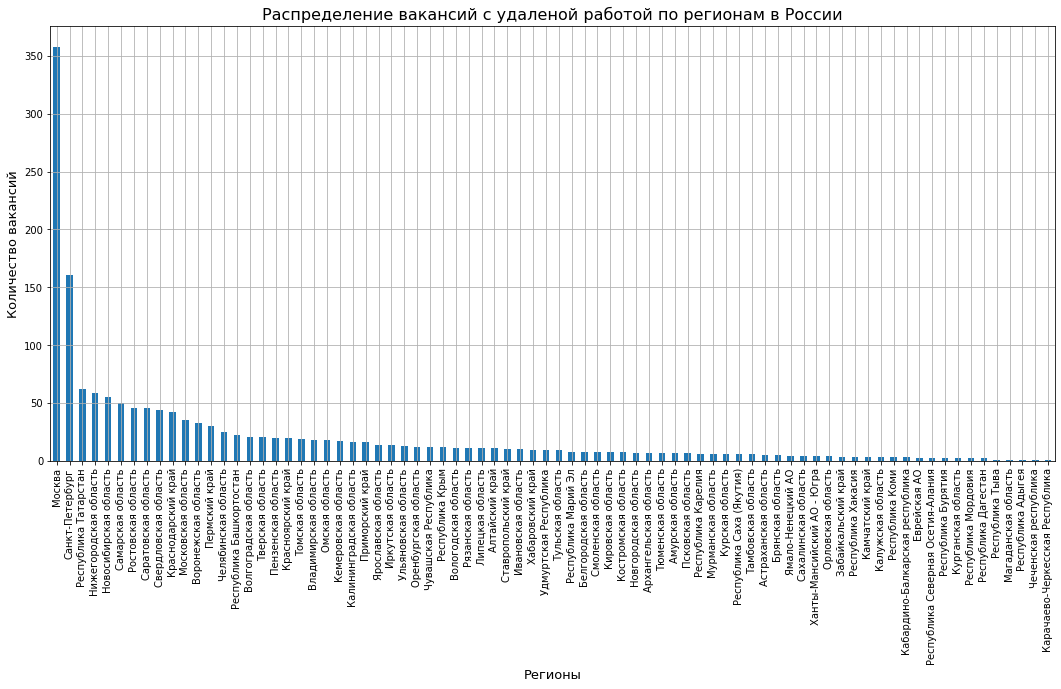

In [73]:
ax = remote('Россия')['vacancy_id'].plot(kind = 'bar', figsize = (18, 8), grid = True)
ax.set_title('Распределение вакансий с удаленой работой по регионам в России', fontsize = 16)
ax.set_xlabel('Регионы', fontsize = 13)
ax.set_ylabel('Количество вакансий', fontsize = 13)

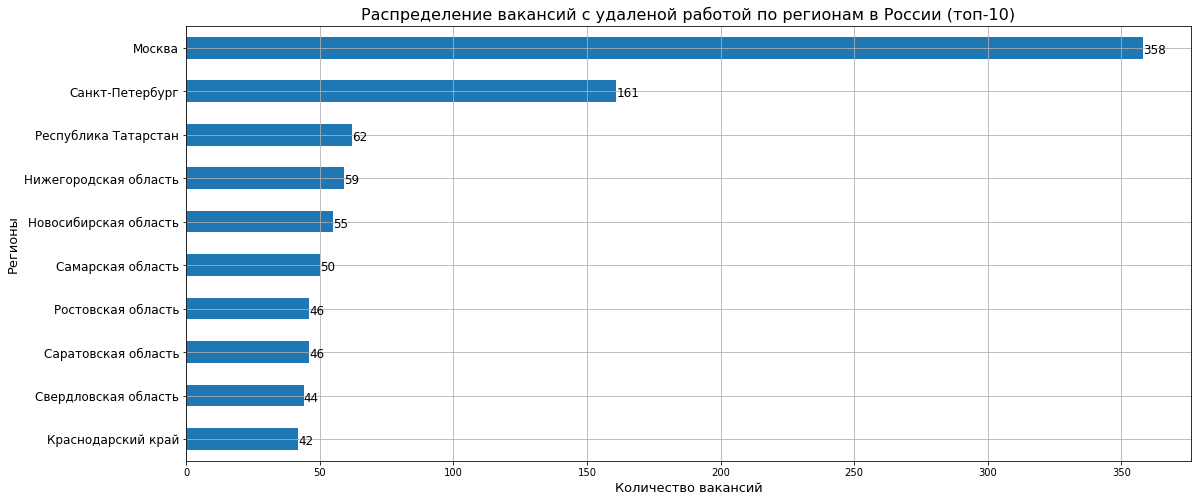

In [74]:
ax = remote('Россия').head(10)['vacancy_id'].plot(kind = 'barh', figsize = (18, 8), grid = True)
ax.set_title('Распределение вакансий с удаленой работой по регионам в России (топ-10)', fontsize = 16)
ax.set_xlabel('Количество вакансий', fontsize = 13)
ax.set_ylabel('Регионы', fontsize = 13)
ax.invert_yaxis()
plt.yticks(fontsize = 12)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_width()), (p.get_width(), p.get_y() + 0.3),
                    ha = 'left', va = 'center', color = 'black', fontsize = 12)

Большое количество предложений вакансий с удаленной работой приходится на Москву и Санкт-Петербург. Тренд на удаленную работу в Москве и Санкт-Петербурге связан с тем, что сотрудникам не приходится тратить время на дорогу до офиса. Причинами найма сотрудников на удаленную работу работодатели считают повышение продуктивности сотрудников. 

По исследованию рекрутинговой компании Hays для работодателей наиболее перспективным регионом в плане поиска удаленных сотрудников является Москва, которая привлекает работодателей высоким уровнем образования и подготовки кадров. [2](https://realnoevremya.ru/articles/74554-kak-otnosyatsya-k-udalennoy-rabote-v-rossii)

В топ-10 не вошла Московская область. Возможно, это связано с тем, что соискатели из области могут устроиться на удаленную работу в Москве без необходимости посещать офис.

В остальных регионах их не так много. От 50 до 62 вакансий с удаленной работой присутствует в Самарской, Новосибирской, Нижегородской областях и республике Татарстан. В остальных регионах количество вакансий не достигает 50.

### 7. Исследование вакансий с частичной занятостью  <a id="part"></a>

In [75]:
def part_job(country):
    part_regions = (test_jobs
                  .query('(country_name == @country) & (type_of_employment == "part")')
                  .groupby('region_name')['vacancy_id'].count()
                  .reset_index()
                  .set_index('region_name')
                  .sort_values(by = 'vacancy_id', ascending = False)
                 )
    return part_regions

In [76]:
part_job('Россия').head(10)

vacancy_id
region_name                      
Москва                         68
Санкт-Петербург                42
Московская область             35
Нижегородская область          18
Краснодарский край             18
Приморский край                16
Саратовская область            16
Самарская область              15
Ростовская область             15
Республика Татарстан           15

In [77]:
part_job('Беларусь')

vacancy_id
region_name            
Минская              28
Витебская            11
Гомельская            6
Брестская             3
Могилевская           3
Гродненская           2

In [78]:
part_job('Казахстан')

vacancy_id
region_name               
Нур-Султан               2
Алматы                   1
Карагандинская           1

Text(0, 0.5, 'Количество вакансий')

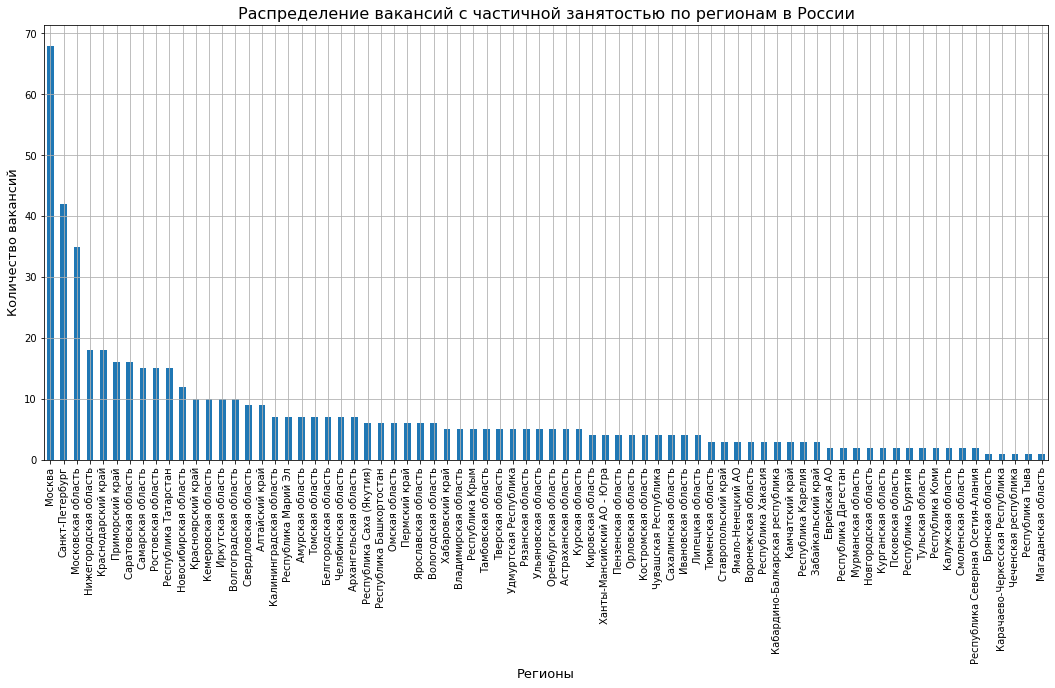

In [79]:
ax = part_job('Россия')['vacancy_id'].plot(kind = 'bar', figsize = (18, 8), grid = True)
ax.set_title('Распределение вакансий с частичной занятостью по регионам в России', fontsize = 16)
ax.set_xlabel('Регионы', fontsize = 13)
ax.set_ylabel('Количество вакансий', fontsize = 13)

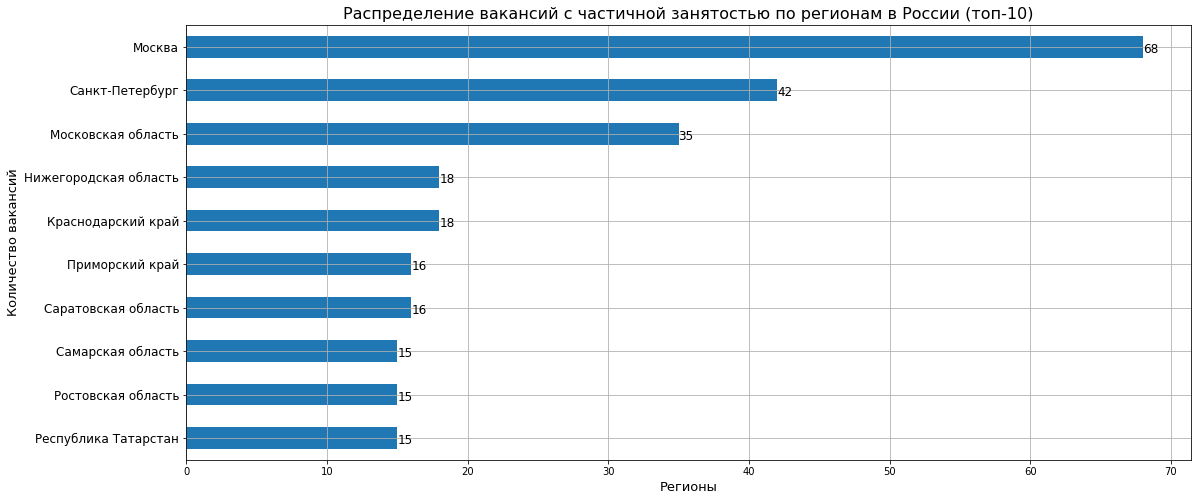

In [80]:
ax = part_job('Россия').head(10)['vacancy_id'].plot(kind = 'barh', figsize = (18, 8), grid = True)
ax.set_title('Распределение вакансий с частичной занятостью по регионам в России (топ-10)', fontsize = 16)
ax.set_xlabel('Регионы', fontsize = 13)
ax.set_ylabel('Количество вакансий', fontsize = 13)
plt.yticks(fontsize = 12)
ax.invert_yaxis()
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_width()), (p.get_width(), p.get_y() + 0.3),
                    ha = 'left', va = 'center', color = 'black', fontsize = 12)

Вакансий с частичной занятостью больше всего в Москве, Санкт-Петербурге и Московской области. Частичная занятость среди тестировщиков не особо распространена. Практически все работодатели предпочитают найм на должность с полным рабочим днем.

###  8. Исследование сезонности распределения вакансий  <a id="seasons"></a>

Рассмотрим для России топ-10 регионов по количеству вакансий на рынке труда. По ним с большой долей вероятности можно будет определить общую картину для регионов.

In [81]:
rus_dict = (test_jobs[test_jobs['country_name'] == 'Россия']
            .groupby('region_name')['vacancy_id'].count()
            .reset_index()
            .sort_values(by = 'vacancy_id', ascending = False)
            .head(10)
           )
rus_dict = rus_dict['region_name'].to_list()

Для Беларуси рассмотрим все регионы, а для Казахстана из-за наличия регионов всего лишь с одной вакансией отберем только регионы с вакансиями больше 30.

In [82]:
blr_dict = (test_jobs[test_jobs['country_name'] == 'Беларусь']
            .groupby('region_name')['vacancy_id'].count()
            .reset_index()
            .sort_values(by = 'vacancy_id', ascending = False)
           )
blr_dict = blr_dict['region_name'].to_list()

In [83]:
kzt_dict = (test_jobs[test_jobs['country_name'] == 'Казахстан']
            .groupby('region_name')['vacancy_id'].count()
            .reset_index()
            .sort_values(by = 'vacancy_id', ascending = False)
           )
kzt_dict = kzt_dict[kzt_dict['vacancy_id'] > 30]['region_name'].to_list()

Составим функцию для отрисовки графиков распределения вакансий по месяцам для каждого региона.

In [84]:
def graph(dictionary):
    for region in dictionary:
        table = test_jobs.query('region_name in @dictionary')
        table = test_jobs[test_jobs['region_name'] == region].groupby(['publication_year', 'publication_month'])['vacancy_id'].count()
        ax = table.plot(kind = 'bar', figsize = (16, 4))
        ax.set_title(region, fontsize = 14)
        ax.set_xlabel('Год и месяц', fontsize = 12)
        ax.set_ylabel('Количество вакансий', fontsize = 12)
        plt.show()

Данные сезонных распределений по России


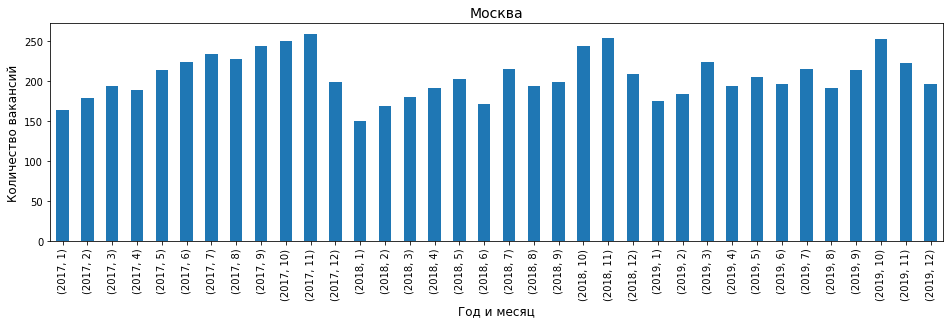

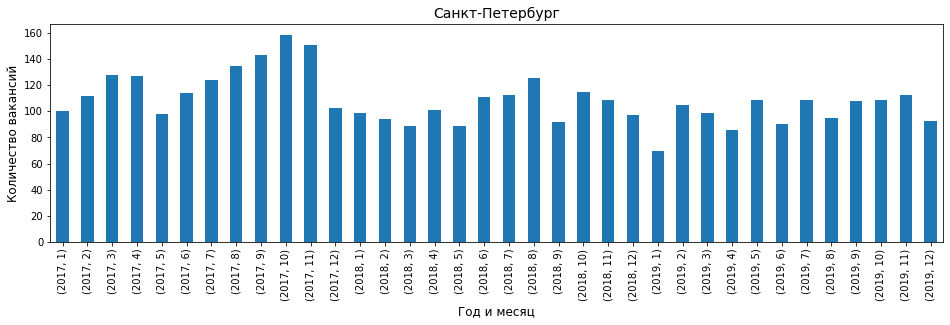

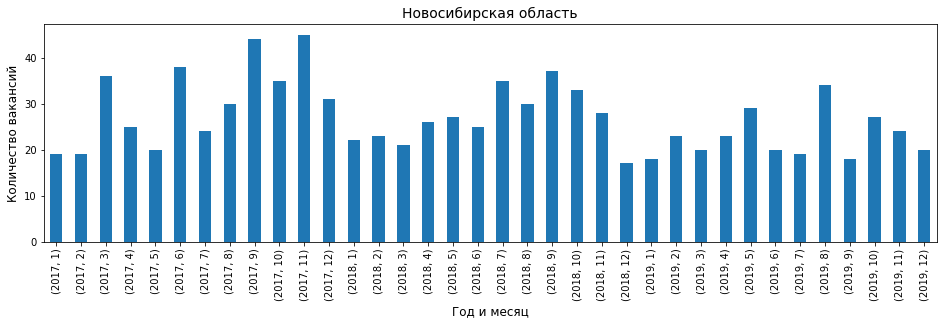

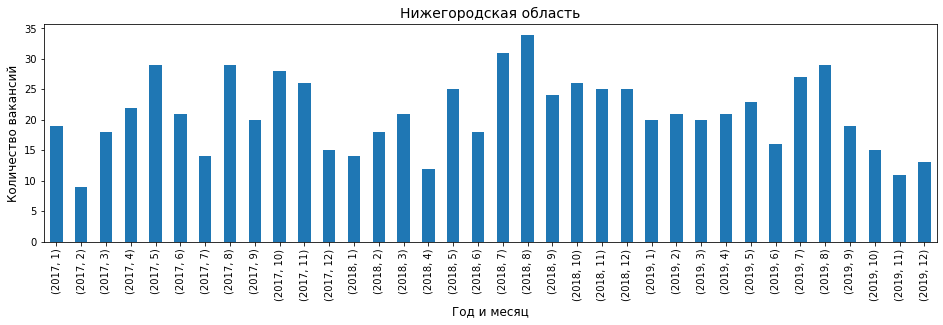

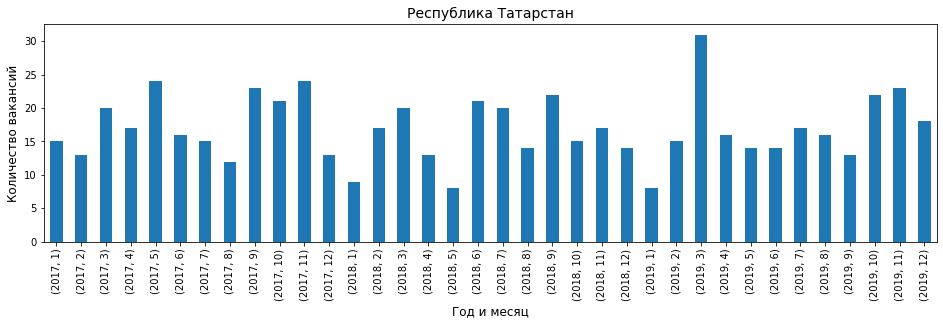

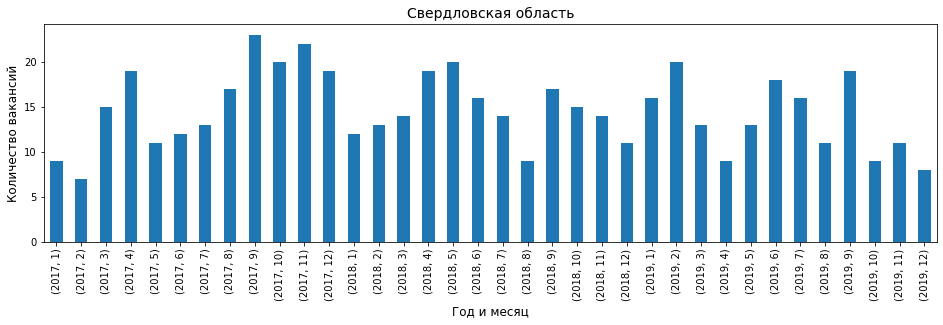

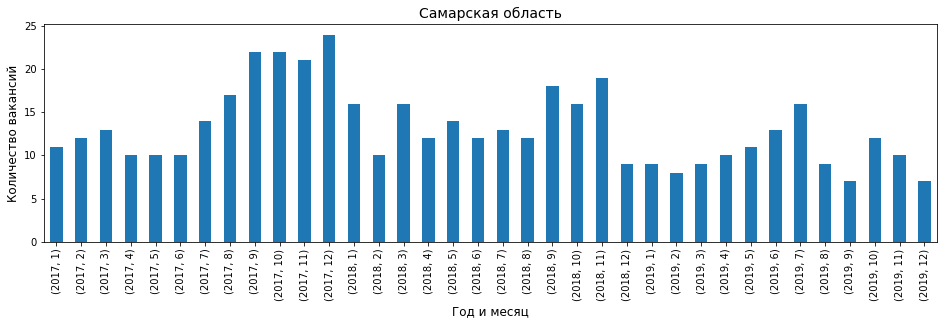

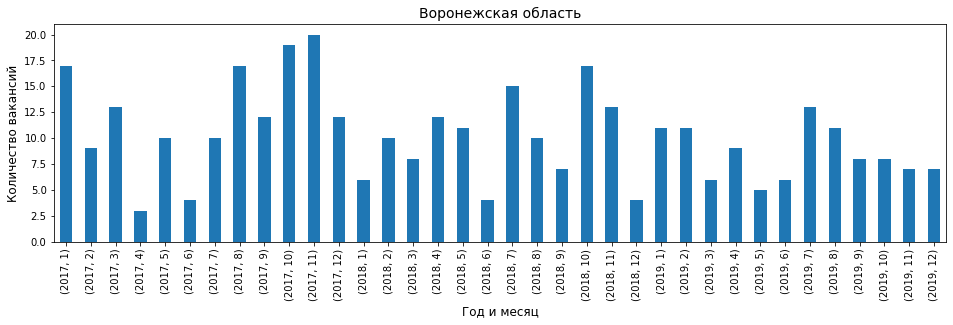

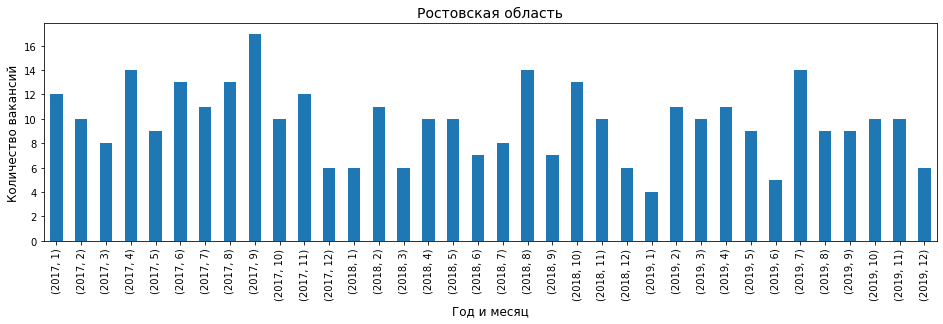

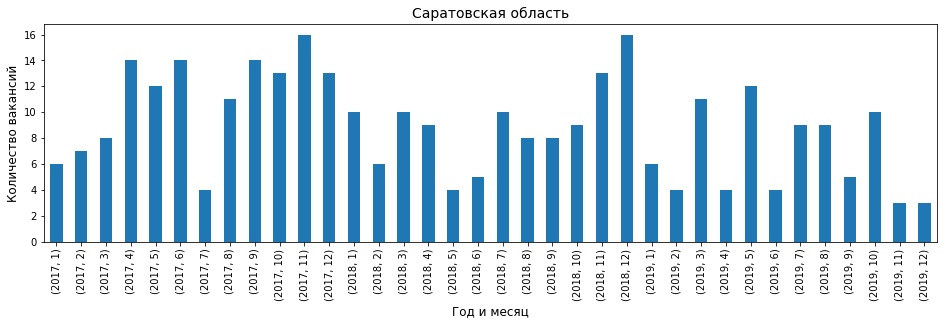

In [85]:
print('Данные сезонных распределений по России')
graph(rus_dict)

Данные сезонных распределений по Беларуси


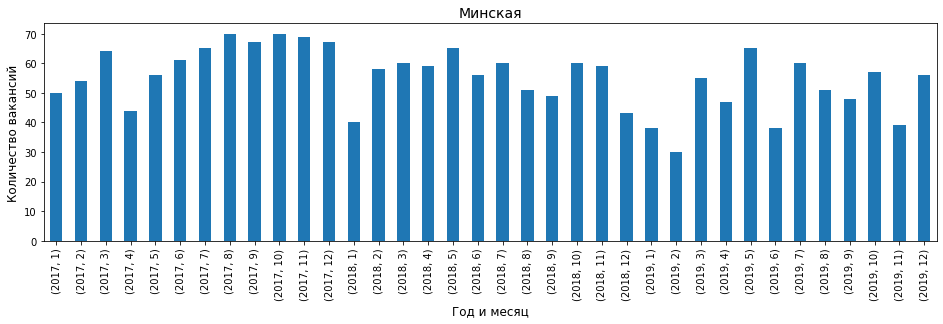

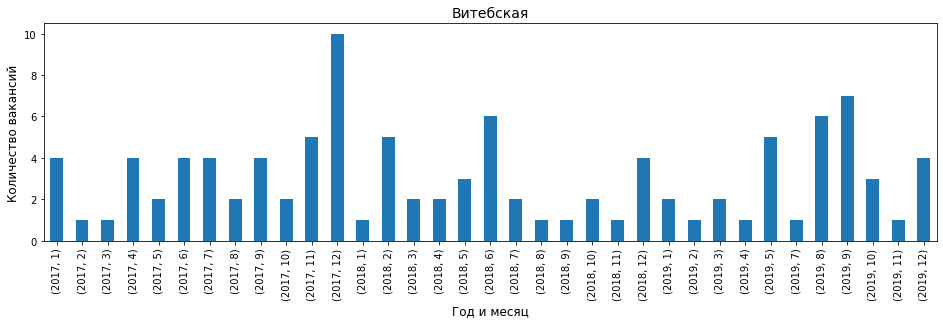

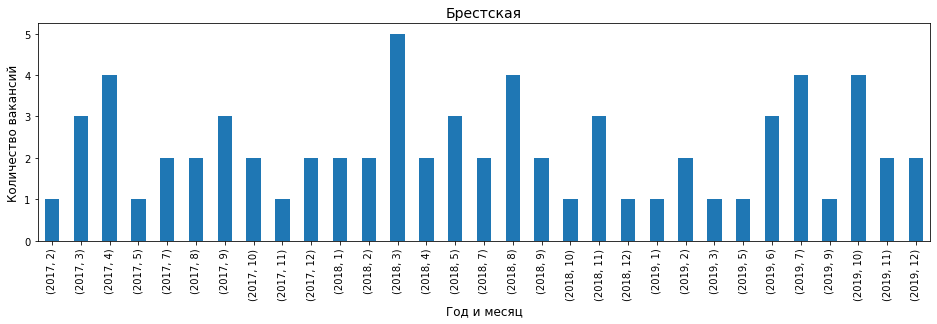

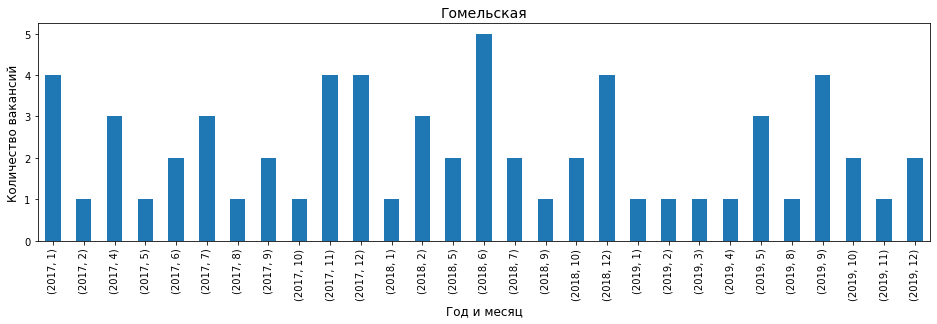

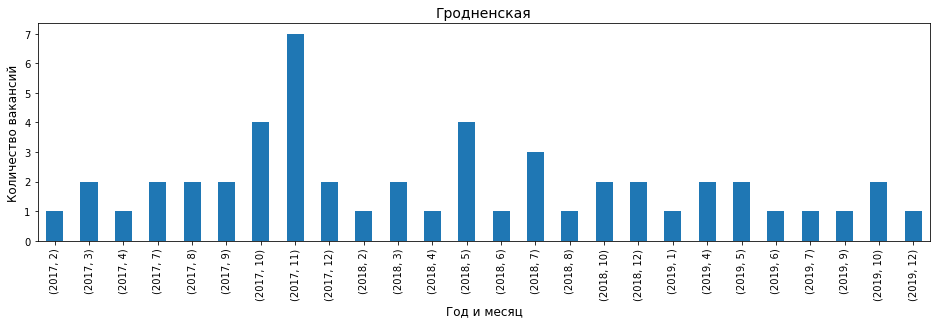

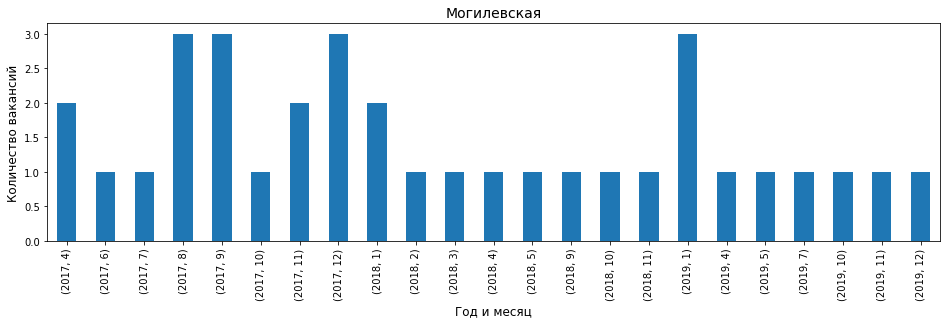

In [86]:
print('Данные сезонных распределений по Беларуси')
graph(blr_dict)

Данные сезонных распределений по Казахстану


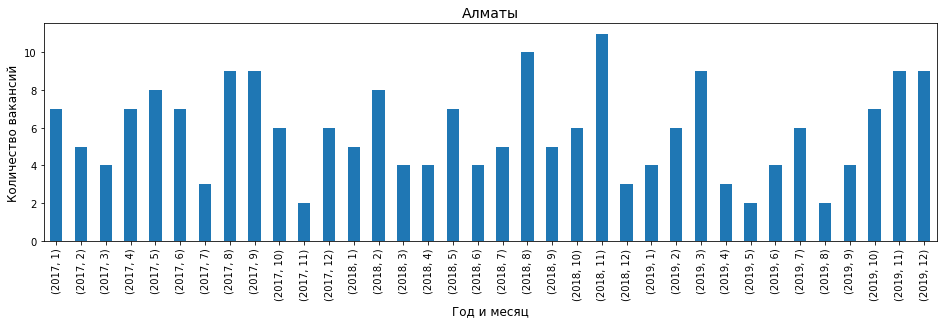

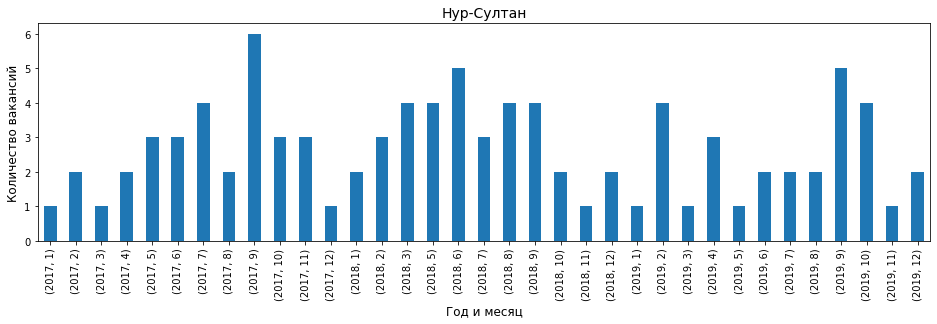

In [87]:
print('Данные сезонных распределений по Казахстану')
graph(kzt_dict)

В Москве явно наблюдается сезонность распределения вакансий: количество активных вакансий плавно растет с начала года, первый небольшой подъем приходится на весну, затем, продолжая расти, количество предложений достигает пика в октябре-ноябре, далее идет резкий спад в декабре-январе и с февраля снова начинается плавный рост. Это обусловлено тем, что летом многие получают бонусы за полугодия и решают оставить свою должность, отправляются в отпуск на лето, а затем осенью начинается активный поиск работы. Такая же потребность в новых кадрах возникает и у компаний. Вдобавок, работодателям часто нужно закрыть вакансии до наступления нового года. 

В Санкт-Петербурге и Новосибирской области можно увидеть такое же распределение сезонности. Однако оно не такое ярко выраженное из-за спада общего количества предложений в 2018 и 2019 годах.

В других регионах, можно сказать, тоже присутствует такая сезонность. Она четко наблюдается в 2017 году в каждом регионе, а в последующие года отличается скачкообразностью из-за постоянно снижаемого количества предложений на рынке.

На фоне всех регионов выделяется Нижегородская область. В ней пик предложения достигается летом.

В Беларуси сложно выделить определенную сезонность. В некоторых регионах предложение в декабре превышает предложение за предыдущие месяцы, что значительно отличается от рынка труда в России.

В Казахстане распределение количества вакансий более приближено в российским реалиям. Пик предложения также часто приходится на осень.

###  9. Исследование вакансий-стажировок  <a id="intern"></a>

In [88]:
intern_dict = ({'стажер', 'стажёр', 'intern', 'стажировка'})

In [89]:
test_jobs['intern'] = 0

In [90]:
def intern_name(name):
    for value in intern_dict:
        if name.count(value) > 0 :
            return 1
    return 0

In [91]:
test_jobs['intern'] = test_jobs['vacancy_name'].apply(intern_name)

In [92]:
def regions_interns(country):
    regions_interns = (test_jobs
                       .query('(country_name == @country) & (intern == 1)')
                       .groupby('region_name')['vacancy_id'].count()
                       .reset_index()
                       .set_index('region_name')
                       .sort_values(by = 'vacancy_id', ascending = False)
                      )
    return regions_interns

In [93]:
regions_interns('Беларусь')

vacancy_id
region_name            
Минская              16
Могилевская           3
Гродненская           2
Витебская             1

In [94]:
regions_interns('Казахстан')

vacancy_id
region_name               
Карагандинская           3
Алматы                   2
Нур-Султан               1

In [95]:
regions_interns('Россия').head(10)

vacancy_id
region_name                      
Москва                        126
Санкт-Петербург                69
Нижегородская область          21
Республика Татарстан           17
Воронежская область            17
Удмуртская Республика          16
Рязанская область              12
Новосибирская область          10
Самарская область               6
Свердловская область            6

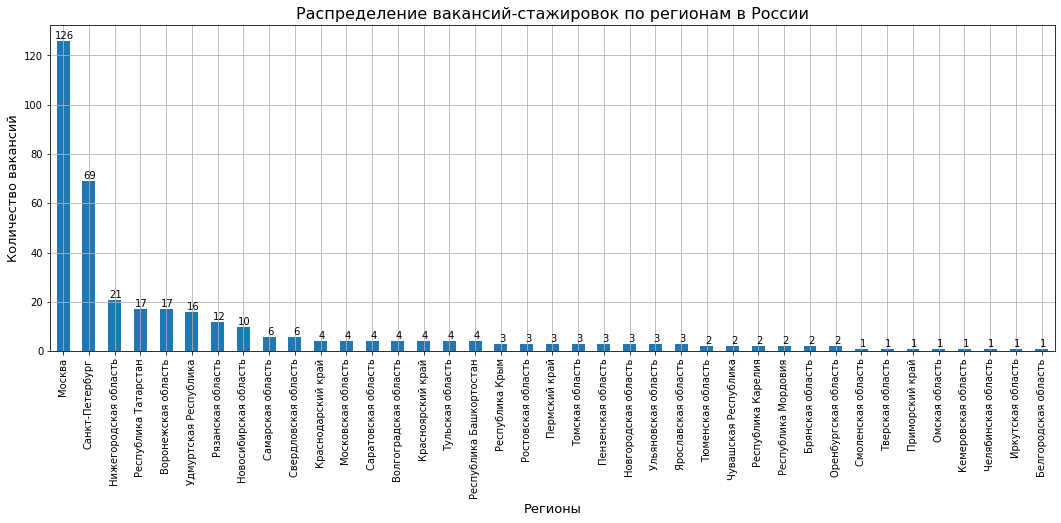

In [96]:
ax = regions_interns('Россия')['vacancy_id'].plot(kind = 'bar', figsize = (18, 6), grid = True)
ax.set_title('Распределение вакансий-стажировок по регионам в России', fontsize = 16)
ax.set_xlabel('Регионы', fontsize = 13)
ax.set_ylabel('Количество вакансий', fontsize = 13)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()),
                    ha = 'center', va = 'bottom', color = 'black', fontsize = 10)

Основное количество вакансий-стажировок представлено в Москве и Санкт-Петербурге. Такое распределение, вероятно, тесно связано с количество профильных учебных заведений в городах. На вакансии-стажировки часто ведется набор действующих студентов или выпускников профильных ВУЗов. В Москве и Санкт-Петербурге наибольшее количество высших учебных заведений, которые способны подготовить IT-специалистов, поэтому в этих городах наблюдается такой отрыв в вакансиях, набирающих стажеров.

###  10. Анализ распределения слов «тестировщик», «QA» или «QC» в вакансиях для джуниор специалистов  <a id="junior"></a>

In [97]:
test_vac = test_jobs[test_jobs['vacancy_name'].str.contains(r'тестировщик|tester')].shape[0]
            
qa_vac = test_jobs[test_jobs['vacancy_name'].str.contains('qa|q/a|quality assurance')].shape[0]

qc_vac = test_jobs[test_jobs['vacancy_name'].str.contains('qс|q/c|quality control')].shape[0]


In [98]:
print('Вакансий «тестировщик»: {} \
      \nВакансий «QA»: {} \
      \nВакансий «QC»: {}'.format(test_vac, qa_vac, qc_vac))

Вакансий «тестировщик»: 8230       
Вакансий «QA»: 9800       
Вакансий «QC»: 7


В общем распределении вакансий виден перекос в сторону вакансий, содержащих в названии quality assurance. 

Теперь взглянем отдельно на вакансии для младших специалистов.

In [99]:
junior_positions = test_jobs[test_jobs['vacancy_name'].str.contains(r'junior|младш')]

In [100]:
print('Всего вакансий джуниор тестировщиков: {}'.format(junior_positions.shape[0]))

Всего вакансий джуниор тестировщиков: 948


In [101]:
test_vac = junior_positions[junior_positions['vacancy_name'].str.contains(r'тестировщик|tester')].shape[0]
            
qa_vac = junior_positions[junior_positions['vacancy_name'].str.contains('qa|q/a|quality assurance')].shape[0]

qc_vac = junior_positions[junior_positions['vacancy_name'].str.contains('qс|q/c|quality control')].shape[0]

In [102]:
print('Вакансий джуниор «тестировщик»: {} \
      \nВакансий джуниор «QA»: {} \
      \nВакансий джуниор «QC»: {}'.format(test_vac, qa_vac, qc_vac))

Вакансий джуниор «тестировщик»: 345       
Вакансий джуниор «QA»: 556       
Вакансий джуниор «QC»: 0


In [103]:
words = basic_clean(''.join(str(junior_positions['vacancy_name'].tolist())))
twograms = pd.Series(nltk.ngrams(words, 2)).value_counts().reset_index()
twograms.columns = ['gram', 'frequency']
twograms.head(10)

gram  frequency
0                (junior, qa)        378
1              (qa, engineer)        291
2          (engineer, junior)        125
3      (младший, тестировщик)        122
4       (тестировщик, junior)        106
5      (тестированию, junior)         93
6         (engineer, младший)         92
7          (младший, инженер)         87
8  (специалист, тестированию)         84
9     (инженер, тестированию)         67

In [104]:
qa = junior_positions[junior_positions['vacancy_name'].str.contains('qa|q/a|quality assurance')]

In [105]:
words = basic_clean(''.join(str(qa['vacancy_description'].tolist())))
twograms = pd.Series(nltk.ngrams(words, 2)).value_counts().reset_index()
twograms.columns = ['gram', 'frequency']
twograms.head(10)

gram  frequency
0         (английского, языка)        168
1               (qa, engineer)        162
2                 (junior, qa)        152
3     (тестовой, документации)        126
4  (программного, обеспечения)        110
5           (умение, работать)        104
6                 (test, case)        101
7   (техническое, образование)         95
8          (работать, команде)         81
9       (ручное, тестирование)         78

In [106]:
tester = junior_positions[junior_positions['vacancy_name'].str.contains(r'тестировщик|tester')]

In [107]:
words = basic_clean(''.join(str(tester['vacancy_description'].tolist())))
twograms = pd.Series(nltk.ngrams(words, 2)).value_counts().reset_index()
twograms.columns = ['gram', 'frequency']
twograms.head(10)

gram  frequency
0     (программного, обеспечения)         89
1      (техническое, образование)         85
2           (высшее, техническое)         83
3             (карьерного, роста)         74
4             (работать, команде)         67
5              (умение, работать)         66
6               (базовые, знания)         62
7                 (знание, основ)         61
8  (функциональное, тестирование)         59
9            (дружный, коллектив)         58

Среди вакансий для джуниор тестировщиков также виден перекос в сторону наличия QA в названии позиции. Можно отметить, что одним из популярных названий является engineer и оно также часто встречается в паре с QA.

В описаниях вакансий для QA одним из основных требований является знание английского языка, далее идут работа с тестовой документацией, тестирование программного обеспечения и проведение ручного тестирования.

В описаниях вакансий тестировщиков на первом месте по частоте упоминаний идет тестирование программного обеспечения, затем для работодателя важно наличие высшего технического образования и базовые знания в данной сфере.

QC в вакансиях для младших специалистов не встретилось.

### Общие выводы <a id="summary"></a>

#### Портрет вакансии
Часто от соискателей требуют наличия опыта тестирования и работы с тестовой документацией,  также часто упоминается об опыте разработки и знании английского языка. Одними из популярных направлений, с которыми предстоит работать будущим сотрудникам - автоматизация тестирования, мобильные приложения и нагрузочное тестирование.

Дополнительно в профиле вакансии в требованиях многие работодатели указывают наличие высшего технического образования и знание SQL, в небольшом количестве вакансий дополнительно указываются знание Java и Atlassian. Можно отметить, что тестировщикам предстоит ввести коммуникации с коллегами и другими командами, поэтому компании указывают в качестве требования "умение работать в команде». Также от тестировщиков требуется наличие аналитического склада ума и понимание жизненного цикла разработки.

В вакансиях имеются требования различных направлений тестирования. Самые популярные требуемые навыки: навыки автоматизированного тестирования, функционального тестирования, нагрузочного тестирования, регрессионного тестирования, тестирования пользовательского интерфейса и ручного тестирования.

Среди вакансий младшего тестировщика преобладают вакансии "без опыта работы". Однако, даже среди вакансий джунов много вакансий, где от соискателей требуют наличия опыта работы до 3 лет.

#### Креативные описания вакансий
С каждым годом растет количество вакансий с креативным описанием (использование современных слов "плюшки", "круто", "классно" и т.д.). Компании стремятся привлечь амбициозных и воодушевленных специалистов, привлекая имеющимися у компании преимуществами. Можно сказать, что такие вакансии часто направлены на более молодых соискателей из-за наличия современных слов в описании.  

#### Динамика и распределение по регионам
Однако, в целом тенденция распределения количества вакансий снижается. В 2017 году количество вакансий тестировщиков было больше, чем в последующие года. 

Из проведенного исследования можно сделать вывод, что помимо очевидных Москвы и Санкт-Петербурга привлекательными регионами для тестировщиков являются Новосибирская и Нижегородская области, Республика Татарстан, Свердловская и Самарская области. В данных регионах самое большое количество вакансий для тестировщиков. Также они лидируют по количеству вакансий с удаленным графиком работы и с частичной занятостью, что может быть достаточно привлекательным для студентов, начинающих свою карьеру.

Вакансий стажировок в других регионах кроме Москвы и Санкт-Петербурга не очень много. Их количество в каждом регионе не достигает даже 30. Здесь можно выделить Нижегородскую область, Республику Татарстан, Воронежскую область и Удмуртскую Республику.

#### Вакансии для джуниор специалистов
Среди вакансий для джуниор специалистов имеется перекос в сторону вакансий, имеющих в названии «QA». В описаниях вакансий для QA одним из основных требований является знание английского языка, далее идут работа с тестовой документацией, тестирование программного обеспечения и проведение ручного тестирования. Далее идут вакансии «тестировщиков». Востребованность в специалистов направления «QC» среди обычных специалистов достаточно маленькая, а позиции для джунов в этом направлении отсутствуют совсем.

#### Сезонность рынка труда
В России практически во всех регионах наблюдается сезонность рынка труда: количество активных вакансий плавно растет с начала года, первый небольшой подъем приходится на весну, затем, продолжая расти, количество предложений достигает пика в октябре-ноябре, далее идет резкий спад в декабре-январе и с февраля снова начинается плавный рост. Это обусловлено тем, что летом многие получают бонусы за полугодия и решают оставить свою должность, отправляются в отпуск на лето, а затем осенью начинается активный поиск работы. Такая же потребность в новых кадрах возникает и у компаний. 

### Рекоммендации <a id="recommend"></a>

В составлении резюме начинающим тестировщикам необходимо сделать упор не только на определенные навыки в работе, такие как разные виды тестирования и знание SQL, но также уделить внимание своим качествам. Многие работодатели ищут коммуникабельных специалистов, и делают упор на умение работать в команде. 

Отдельно стоит отметить, что многие компании в требованиях указывали знание английского языка, поэтому соискателям следует улучшать не только технические навыки разработчиков, но и уделить внимание улучшению английского языка и работе с тестовой документацией на английском.

Имеется достаточно большой выбор вакансий для соискателей без опыта работы. Такие вакансии занимают 12,8% рынка (2914 вакансий), среди них 948 вакансий для джуниор специалистов. Кандидаты без опыта работы имеют выбор и могут пробовать трудоустроиться не только в качестве младшего специалиста, но и обычным тестировщиком, если их навыки отвечают требованиям, описанным в вакансиях. При этом, соискателям стоит уделять внимание не только опыту работы, который указан в требованиях в "шапке" вакансии, но и тому, который указан в самом описании вакансии, так как в некоторых вакансиях эти данные могут различаться.

Вполне очевидно, что основное количество вакансий приходится на Москву и Санкт-Петербург. Однако, стоит отметить, что в этих городах также преобладает большое количество вакансий с удаленным графиком работы и с частичной занятостью. В 2020 году с введением карантинных мер из-за пандемии рынок труда был вынужден приспособиться к новой ситуации и многие компании перешли в режим удаленной работы на неизвестный срок. Поэтому количество вакансий с удаленной работой (особенно для IT компаний) должно было возрасти.  Из этого следует, что многие кандидаты могут попробовать трудоустроиться в компании, расположенные в других регионах, и удаленно работать без переезда в другой город.

На рынке труда тестировщиков, как и на рынке труда в целом, существует определенная сезонность. Первый небольшой пик достигается в апреле-мае, вторая и самая большая волна приходится на октябрь-ноябрь. Эти месяцы являются самыми привлекательными для того, чтобы начать активный поиск работы как для обычных специалистов, так и для начинающих. 